# Classifieurs connus - Random Forest
## Objectif
L'objectif de ce notebook est de tester un classifieur connu, le Random Forest, sur le jeu de données de l'étude.

## Hypothèses
Les hypothèses quant aux résultats attendus sont les suivants :
- Une précision plus faible que celle du CNN
- Un temps d'entraînement plus faible que celui du CNN

## Etapes de la démarche
1. Remplacer le modèle de base du CNN par le classifier Random Forest
2. Tester le modèle sur le jeu de données
3. Calculer les métriques de performance
4. Comparer les résultats avec les résultats du CNN

## Conclusion
Les résultats obtenus sont les suivants :
- Une précision plus faible que celle du CNN
- Un temps d'entraînement plus faible que celui du CNN

Les résultats sont en accord avec l'hypothèse de départ. Random Forest permet d'obtenir une valeur de précision de référence rapidement mais démontre que les CNN sont une option plus fiable pour ce type de problème.

In [1]:
from PIL import Image
import os
import numpy as np

# Define the folders where your data is stored
train_folder = 'train'
test_folder = 'test'
val_folder = 'val'

# Define the subfolders within each folder where the images are stored
subfolders = ['NORMAL', 'PNEUMONIA']

# Define the size of the images you want to resize your images to
img_width, img_height = 256, 256 # Function to load and resize images from a folder

In [2]:
# Function to load and resize images from a folder
def load_images_from_folder(folder, limit_per_subfolder=None):
    X = []
    y = []
    for subfolder in subfolders:
        folder_path = os.path.join(folder, subfolder)
        if limit_per_subfolder:
            # Get amount of random filenames from the folder
            filenames = np.random.choice(os.listdir(folder_path), limit_per_subfolder, replace=False)
        else:
            filenames = os.listdir(folder_path)
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            # Resize the image to the desired size
            img = img.resize((img_width, img_height))

            # Convert RGB image to grayscale
            img = img.convert('L')

            # Convert the image to a NumPy array and append it to X
            img = np.array(img)
            X.append(img)

            # Append the corresponding label to y
            y.append(subfolders.index(subfolder))

    X = np.array(X)
    y = np.array(y)
    return X, y

In [3]:
# Generate augmented for the training set
from common.data_augmentation import generate_augmented_images
generate_augmented_images(train_folder, 'NORMAL', image_size=(img_width, img_height))
generate_augmented_images(train_folder, 'PNEUMONIA', image_size=(img_width, img_height))

Found 1341 images belonging to 1 classes.
Additional count of images to generate: 0
Given NORMAL count: 1341
Augmented NORMAL count: 5000
Found 3874 images belonging to 1 classes.
Additional count of images to generate: 0
Given PNEUMONIA count: 3874
Augmented PNEUMONIA count: 5000


In [4]:
# Load the training data
# Get min value between the number of normal images and the number of pneumonia images
train_folder = f"{train_folder}_augmented"
min_images = min(len(os.listdir(os.path.join(train_folder, subfolders[0]))), len(os.listdir(os.path.join(train_folder, subfolders[1]))))
X_train, y_train = load_images_from_folder(train_folder, min_images)

# Load the test data
X_test, y_test = load_images_from_folder(test_folder)

# Load the validation data
X_val, y_val = load_images_from_folder(val_folder)

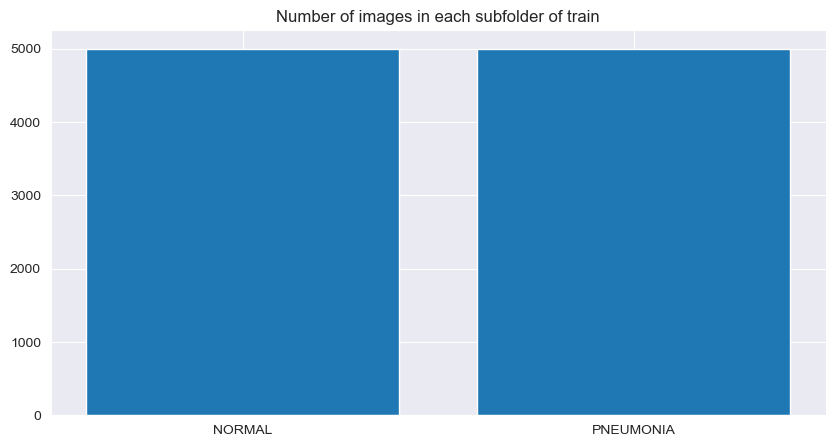

In [5]:
# Make a matplot figure to show how many images are in each subfolder of train
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(os.listdir(os.path.join(train_folder, subfolder))) for subfolder in subfolders])
plt.title('Number of images in each subfolder of train')
plt.show()

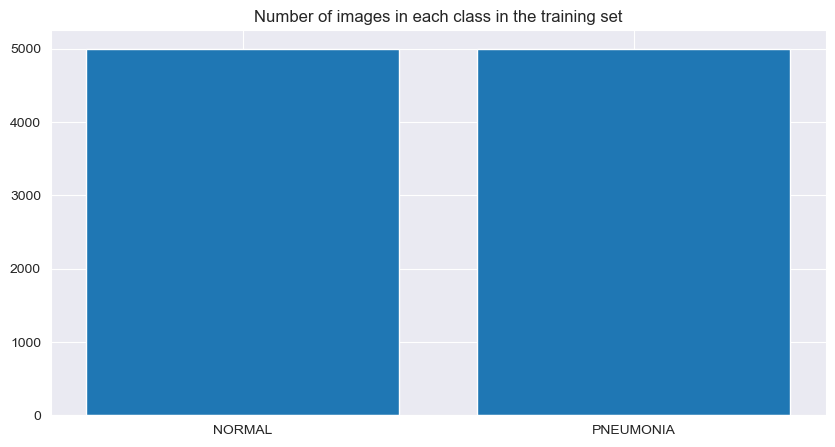

In [6]:
# Make a matplot figure to show how many images if each class in the training set
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(y_train[y_train == i]) for i in range(len(subfolders))])
plt.title('Number of images in each class in the training set')
plt.show()

In [7]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

X_train = X_train.reshape(len(X_train), img_width, img_height, 1)
X_test = X_test.reshape(len(X_test), img_width, img_height, 1)
X_val = X_val.reshape(len(X_val), img_width, img_height, 1)

(256, 256, 1)


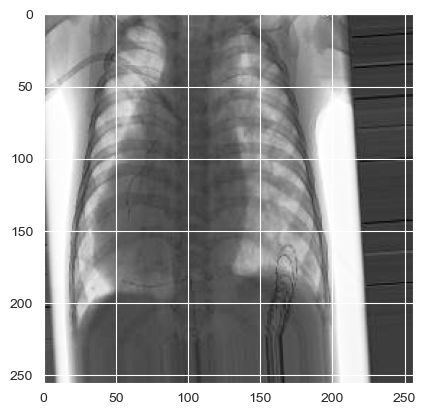

In [8]:
single_image = X_train[np.random.randint(len(X_train))]
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')

In [9]:
# Define model metrics
from keras.metrics import AUC

metrics = [
    "accuracy",
    AUC(name='auc')
]

## Random Forest
On implémente le modèle de Random Forest avec Tensorflow Decision Forests. On utilise la fonction create_model pour garder une cohérence avec le template. On utile RandomizedSearchCV pour faire de la cross validation et trouver les meilleurs hyperparamètres possibles parmi une liste fournie, notamment afin d'observer la précision maximale pouvant être obtenue grâce au classifieur Random Forest.

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Define the model architecture
def create_model():
    return RandomForestClassifier(random_state=42)

In [11]:
# Cross validation with RandomSearchCV
X_train_temp = X_train.reshape(len(X_train), img_width * img_height)
X_val_temp = X_val.reshape(len(X_val), img_width * img_height)

from sklearn.model_selection import RandomizedSearchCV

# Set RandomSearchCV parameters for Random Forest
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'max_features': ['log2']
}

# Set RandomSearchCV parameters for training
nb_folds = 10

model = create_model()
estimators = RandomizedSearchCV(model, param_distributions=params, n_iter=nb_folds, cv=nb_folds, verbose=3, random_state=42)
estimators.fit(X_train_temp, y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.803 total time=   3.1s
[CV 2/10] END max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.800 total time=   3.0s
[CV 3/10] END max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.811 total time=   2.9s
[CV 4/10] END max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.822 total time=   2.9s
[CV 5/10] END max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.784 total time=   2.9s
[CV 6/10] END max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.815 total time=   2.9s
[CV 7/10] END max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=0.7

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'max_features': ['log2'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=3)

On observe que le temps d'entrainement varie enntre 2 et 20 secondes selon les paramètres choisis. Etant donné que scikit-learn ne fonctionne pas sur GPU, le temps d'entrainement semble beaucoup plus rapidement que pour le CNN de référence, qui demande 20 secondes par epoch en tournant sur le GPU (on pouvait observer environ 120 secondes par epoch avant l'utilisation du GPU). Le temps d'entrainement est plus rapidement avec un classifieur Random Forest, mais la précision est moins bonne, comme observé dans la suite du notebook.

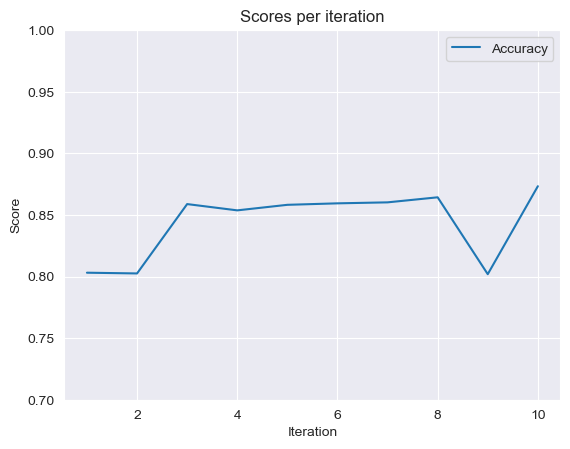

In [26]:
# Plot score per iteration
import matplotlib.pyplot as plt
means = estimators.cv_results_['mean_test_score']
plt.title('Scores per iteration')
plt.plot(range(1, len(means)+1), means, label='Accuracy')
plt.ylim(0.7, 1.0)
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.legend()
plt.show()

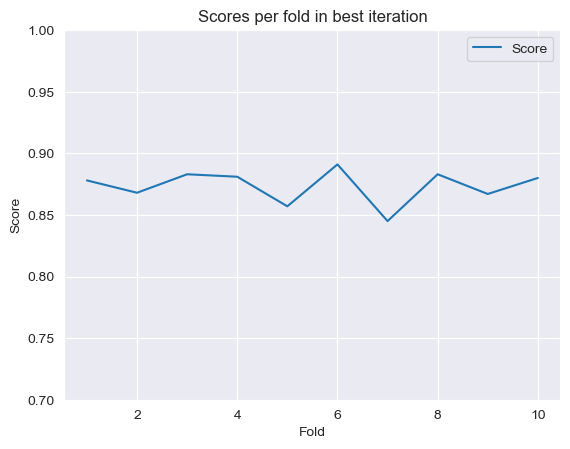

In [25]:
# Plot score per fold for the best iteration
scores_per_fold = []
for i in range(nb_folds):
    scores_per_fold.append(estimators.cv_results_[f'split{i}_test_score'][estimators.best_index_])

plt.title('Scores per fold in best iteration')
plt.plot(range(1, len(scores_per_fold)+1), scores_per_fold, label='Score')
plt.ylim(0.7, 1.0)
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.show()

On remarque que le score reste quasi stable au fil des itérations selon les paramètres passés.

In [14]:
# Print best parameters found
print("Best params found: ")
print("N° Estimators: ", estimators.best_params_['n_estimators'])
print("Max depth: ", estimators.best_params_['max_depth'])
print("Min samples split: ", estimators.best_params_['min_samples_split'])
print("Min samples leaf: ", estimators.best_params_['min_samples_leaf'])
print("Max features: ", estimators.best_params_['max_features'])

Best params found: 
N° Estimators:  300
Max depth:  15
Min samples split:  15
Min samples leaf:  2
Max features:  log2


In [15]:
# Train the model on the whole training set with the best parameters found
model = RandomForestClassifier(
    n_estimators=estimators.best_params_['n_estimators'],
    max_depth=estimators.best_params_['max_depth'],
    min_samples_split=estimators.best_params_['min_samples_split'],
    min_samples_leaf=estimators.best_params_['min_samples_leaf'],
    max_features=estimators.best_params_['max_features'],
    random_state=42
)
model.fit(X_train_temp, y_train)

RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=2,
                       min_samples_split=15, n_estimators=300, random_state=42)

In [16]:
# Save the model
import joblib
joblib.dump(model, 'random_forest.joblib')

['random_forest.joblib']

In [17]:
# Load the model
model = joblib.load('random_forest.joblib')

In [18]:
X_test_temp = X_test.reshape(len(X_test), img_width * img_height)
y_pred_test = model.predict(X_test_temp)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

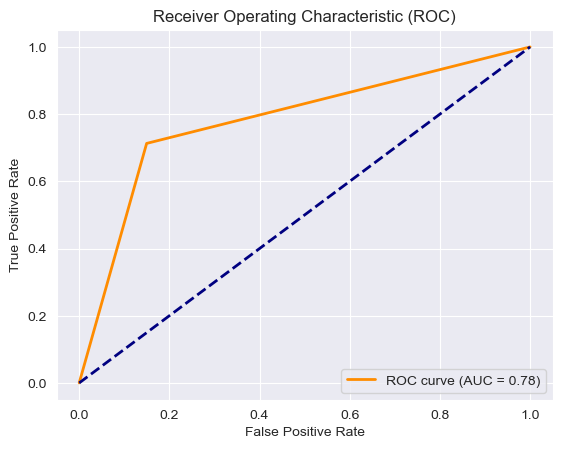

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score for the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and show AUC score on the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test.flatten())
print(cm)

[[199  35]
 [112 278]]


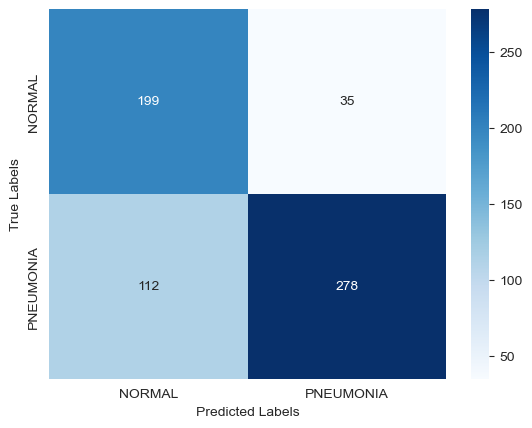

In [21]:
# Plot the confusion matrix
class_names = subfolders
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

On remarque que le classifieur a tendance à prédire plus de faux négatifs que de faux positifs. Cela signifie que le classifieur a tendance à prédire que des patients sont sains alors qu'ils sont malades. Cela peut être dangereux car les patients ne seront pas traités et risquent de développer des complications. Dans le CNN de référence, on observe l'exact inverse dans ce rapport faux positifs / faux négatifs, ce qui constitue un résultat beaucoup plus convaincant.

In [22]:
# Compute the classification report for test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.64      0.85      0.73       234
   PNEUMONIA       0.89      0.71      0.79       390

    accuracy                           0.76       624
   macro avg       0.76      0.78      0.76       624
weighted avg       0.80      0.76      0.77       624



La précision du modèle avec les meilleurs paramètres trouvés est seulement de 0.76, ce qui est très faible comparé au CNN de référence qui atteint 0.92. On remarque que la précision est très faible pour la classe "PNEUMONIA", ce qui est cohérent avec le fait que le classifieur a tendance à prédire plus de faux négatifs que de faux positifs.

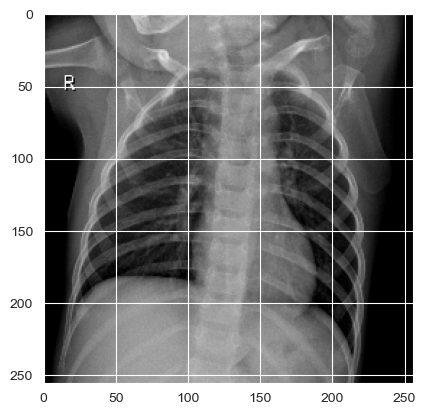

C:\ProgramData\anaconda3\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


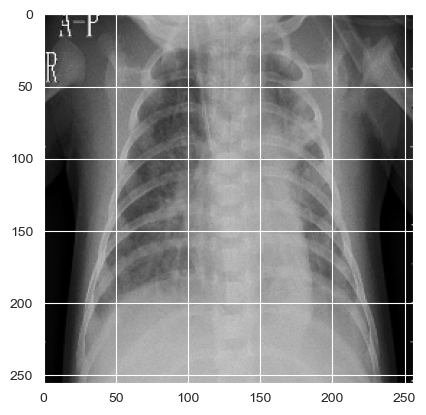

In [23]:
# Predict on some validation images
from common.cam import get_img_array
import cv2
import matplotlib.pyplot as plt 

images = [
    {
        "path": "./val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
    },
    {
        "path": "./val/PNEUMONIA/person1946_bacteria_4874.jpeg"
    }
]

for image in images:
    image_temp = cv2.imread(image["path"])
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_RGB2GRAY)
    image_temp = cv2.resize(image_temp, (img_width, img_height))

    plt.imshow(image_temp, cmap=plt.cm.gray)
    plt.show()
    
    image["array"] = get_img_array(image["path"], size=(img_width, img_height))


In [24]:
# Predict
for image in images:
    pred = model.predict(image["array"].reshape(1, img_width * img_height))
    print(pred)
    # Display predicted class
    print("Predicted class: {}".format(subfolders[int(pred[0])]))

[1]
Predicted class: PNEUMONIA
[1]
Predicted class: PNEUMONIA


Les deux images sont prédites comme étant des images de patients malades, ce qui est incohérent avec les résultats attendus. Le CNN de référence avait prédit correctement la première image comme étant une image de patient sain et la deuxième comme étant une image de patient malade. Les prédictions de RandomForest sont donc moins fiables que celles du CNN de référence et confirme les résultats observés dans la matrice de confusion.